# YAASS Dataset

#### The dataset below includes demographic information and multiple clinical measures taken in 3 populations: healthy controls, those at clinical high risk for psychosis, and those at familial high risk.

In [116]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [117]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests

/Users/ebarrick/Work/Expts/Code
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex', 'reshape2',
       'effsize', 'lsmeans', 'estimability', 'lmerTest', 'lme4', 'Matrix',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='|S12')

In [153]:
#Function to assign names to disorders in FAME dataset
def dx_name(data):
    d = {0:'None', 1:'MDD', 2:'Anxiety', 3:'Sub_abuse', 4:'ADHD', 
         5:'Eating', 6:'Schizotypal', 7:'2_co', 8: '3_co', 9:'4_co','999':'na'}
    dx = d[data]
    return dx 

raw_sh = pd.read_excel(path2data + 'Bx_Paper_YAASS_Feb2017.xlsx')
raw_sh['Gender'].replace(2, 'female', inplace=True)
raw_sh['Gender'].replace(1,'male', inplace=True)

raw_sz = pd.read_excel(path2data + 'SCORE Data_Bx_IRI_SocialFx.xlsx')
raw_sz['Group'].replace(2, 'SZ', inplace=True)

raw_fhr = pd.read_excel(path2data + 'FAME_Neuropsych_NEW.xlsx')
raw_fhr['Group'].replace(1, 'FHR', inplace=True)
raw_fhr['Gender'].replace(2, 'female', inplace=True)
raw_fhr['Gender'].replace(1,'male', inplace=True)
raw_fhr['DSMDisorderType'].replace('NaN','999', inplace=True)
raw_fhr['DSMDisorder'].replace(0, 'No', inplace=True)
raw_fhr['DSMDisorder'].replace(1, 'Yes', inplace=True)
raw_fhr['DSMDisorderType'] = raw_fhr.DSMDisorderType.apply(dx_name)
# raw_fhr['DSMcomorbidities'] = raw_fhr.DSMcomorbidities.apply(dx_name)

g = raw_sh.append(raw_sz)

raw1 = g.append(raw_fhr)
pd.set_option('display.max_columns', 500)

raw = raw1[['ID','Group','Gender','Age','IQ','Education','Ethnicity','DSMDisorder','DSMDisorderType','DSMcomorbidities',
           'Medication','IRI_EC','IRI_FS','IRI_PD','IRI_PT','IRI_Total', 'SIPS_Disorganized','SIPS_Negative',
           'SIPS_Positive','SIPS_General','SocAdjScale_SocialLeisure','SocAdjScale_Work','GFS_Social','GFS_Role',
           'Chapman_PAS','Chapman_MIS','Chapman_RTS','Chapman_PhAS','Chapman_SocAnh']].copy()

In [137]:
raw.head()

,ID,Group,Gender,Age,IQ,Education,Ethnicity,DSMDisorder,DSMDisorderType,DSMcomorbidities,Medication,IRI_EC,IRI_FS,IRI_PD,IRI_PT,IRI_Total,SIPS_Disorganized,SIPS_Negative,SIPS_Positive,SIPS_General,SocAdjScale_SocialLeisure,SocAdjScale_Work,GFS_Social,GFS_Role,Chapman_PAS,Chapman_MIS,Chapman_RTS,Chapman_PhAS,Chapman_SocAnh
0,26105,HC,female,33,102,12,NaN,NaN,NaN,NaN,NaN,36,30,12,32,110,0,0,0,0,49,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26120,HC,male,22,133,16,NaN,NaN,NaN,NaN,NaN,24,33,14,31,102,0,2,1,0,42,0,10,9,NaN,NaN,NaN,NaN,NaN
2,26130,HC,female,19,118,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,45,51,10,9,NaN,NaN,NaN,NaN,NaN
3,26133,HC,female,24,103,17,NaN,NaN,NaN,NaN,NaN,34,34,16,33,117,2,1,4,2,62,55,10,9,NaN,NaN,NaN,NaN,NaN
4,26137,HC,male,19,133,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,45,NaN,9,9,NaN,NaN,NaN,NaN,NaN


### Demographics

In [138]:
raw.groupby('Group')['ID'].nunique()

Group
FHR    19
HC     24
HR     27
SZ     26
Name: ID, dtype: int64

In [139]:
#Even split in HC group, more males in HR and SZ group - unsurprising...however mostly female in GHR group

raw.groupby('Group')['Gender'].value_counts()

Group        
FHR    female    14
       male       5
HC     male      12
       female    12
HR     male      18
       female     9
SZ     1         16
       2         10
dtype: int64

Group       
FHR    count    19.000000
       mean     27.421053
       std       3.920258
       min      20.000000
       25%      24.500000
       50%      27.000000
       75%      31.000000
       max      33.000000
HC     count    24.000000
       mean     22.750000
       std       4.002716
       min      18.000000
       25%      19.750000
       50%      22.000000
       75%      24.750000
       max      33.000000
HR     count    27.000000
       mean     21.629630
       std       4.404090
       min      15.000000
       25%      18.000000
       50%      22.000000
       75%      23.500000
       max      34.000000
SZ     count    26.000000
       mean     38.692308
       std      10.279180
       min      21.000000
       25%      31.250000
       50%      38.500000
       75%      44.750000
       max      58.000000
dtype: float64


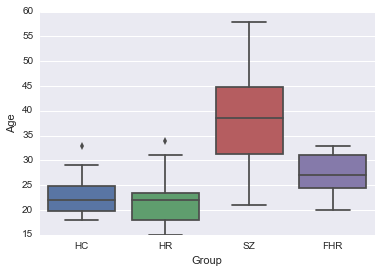

In [140]:
#Age
g=raw.groupby('Group')
print (g.Age.describe())

sns.boxplot(x='Group',y='Age',data=raw)

In [44]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group       
FHR    count     18.000000
       mean     117.000000
       std        9.779931
       min       95.000000
       25%      115.500000
       50%      118.000000
       75%      121.750000
       max      136.000000
HC     count     24.000000
       mean     115.125000
       std       10.330674
       min       97.000000
       25%      107.750000
       50%      117.500000
       75%      119.000000
       max      138.000000
HR     count     24.000000
       mean     106.791667
       std       17.688068
       min       79.000000
       25%       91.750000
       50%      106.500000
       75%      122.250000
       max      139.000000
SZ     count     26.000000
       mean     108.076923
       std       13.323432
       min       82.000000
       25%       99.000000
       50%      107.500000
       75%      118.750000
       max      133.000000
dtype: float64
Between group t-test on IQ HC and HR
t(46) = 1.99, p = 0.052
Between group t-test on IQ HC and SZ
t(48) = 2.

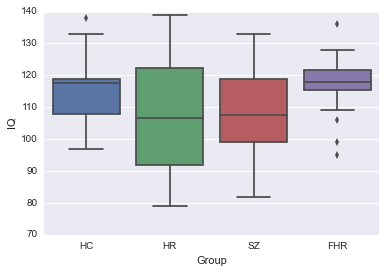

In [141]:
#IQ: Looks like FHR has significantly higher IQ than HC (and therefore all groups)

i = raw_IQ.groupby('Group')

print (i.IQ.describe())
print ('Between group t-test on IQ HC and HR')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'HR']['IQ'])

print ('Between group t-test on IQ HC and SZ')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'SZ']['IQ'])

print ('Between group t-test on IQ HC and FHR')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'FHR']['IQ'])

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

### Data Quality Check

In [142]:
#Dataframe where any row that has NAN value is dropped- will tell us how many participants have at least some missing 
#data
sh_no_na = raw_sh.dropna()

In [143]:
# looks like most participants have some missing values...
sh_no_na.groupby('Group')['ID'].nunique()

Group
HC    8
HR    9
Name: ID, dtype: int64

In [144]:
#Dataframe where any row that has less than 6 entries - which corresponds to anything other than demographic 
#information/subject ID entered - are dropped. These are participants that should not be included in the analyses.
df_cleaned = raw.dropna(thresh=6)

In [145]:
#one participant that has no measures taken: 26195
df_cleaned.groupby('Group')['ID'].nunique()

Group
FHR    19
HC     24
HR     26
SZ     26
Name: ID, dtype: int64

### Looking at Measures

In [146]:
raw.head()

,ID,Group,Gender,Age,IQ,Education,Ethnicity,DSMDisorder,DSMDisorderType,DSMcomorbidities,Medication,IRI_EC,IRI_FS,IRI_PD,IRI_PT,IRI_Total,SIPS_Disorganized,SIPS_Negative,SIPS_Positive,SIPS_General,SocAdjScale_SocialLeisure,SocAdjScale_Work,GFS_Social,GFS_Role,Chapman_PAS,Chapman_MIS,Chapman_RTS,Chapman_PhAS,Chapman_SocAnh
0,26105,HC,female,33,102,12,NaN,NaN,NaN,NaN,NaN,36,30,12,32,110,0,0,0,0,49,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26120,HC,male,22,133,16,NaN,NaN,NaN,NaN,NaN,24,33,14,31,102,0,2,1,0,42,0,10,9,NaN,NaN,NaN,NaN,NaN
2,26130,HC,female,19,118,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,45,51,10,9,NaN,NaN,NaN,NaN,NaN
3,26133,HC,female,24,103,17,NaN,NaN,NaN,NaN,NaN,34,34,16,33,117,2,1,4,2,62,55,10,9,NaN,NaN,NaN,NaN,NaN
4,26137,HC,male,19,133,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,45,NaN,9,9,NaN,NaN,NaN,NaN,NaN


In [147]:
#Dataframe dropping participants without an IQ value
raw_IRI = raw[np.isfinite(raw['IRI_EC'])]
raw_IRI = raw[np.isfinite(raw['IRI_FS'])]
raw_IRI = raw[np.isfinite(raw['IRI_PD'])]
raw_IRI = raw[np.isfinite(raw['IRI_PT'])]

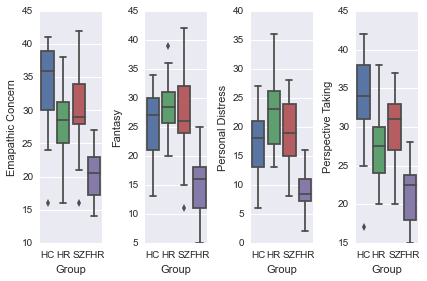

In [148]:
fig = plt.figure()
iri = fig.add_subplot(141)
sns.boxplot(y='IRI_EC', x='Group', data = raw_IRI)
plt.ylabel('Emapathic Concern')
iri = fig.add_subplot(142)
sns.boxplot(y='IRI_FS', x='Group', data = raw_IRI)
plt.ylabel('Fantasy')
iri = fig.add_subplot(143)
sns.boxplot(y='IRI_PD', x='Group', data = raw_IRI)
plt.ylabel('Personal Distress')
iri = fig.add_subplot(144)
sns.boxplot(y='IRI_PT', x='Group', data = raw_IRI)
plt.ylabel('Perspective Taking')
fig.tight_layout()

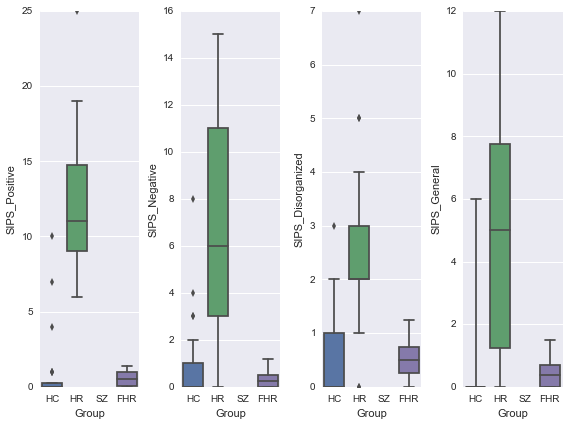

In [149]:
fig = plt.figure(figsize=(8, 6))
iri = fig.add_subplot(141)
sns.boxplot(y='SIPS_Positive', x='Group', data = raw)
iri = fig.add_subplot(142)
sns.boxplot(y='SIPS_Negative', x='Group', data = raw)
iri = fig.add_subplot(143)
sns.boxplot(y='SIPS_Disorganized', x='Group', data = raw)
iri = fig.add_subplot(144)
sns.boxplot(y='SIPS_General', x='Group', data = raw)
fig.tight_layout()

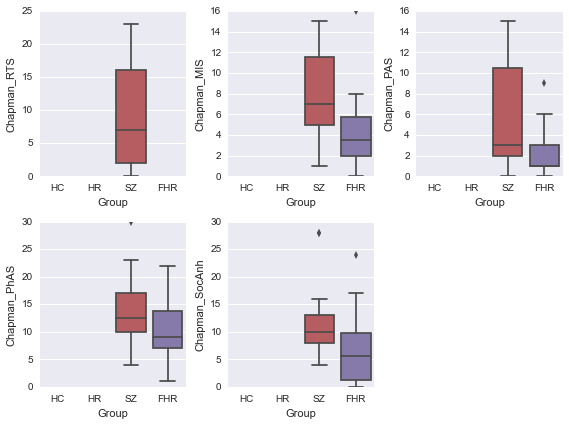

In [150]:
fig = plt.figure(figsize=(8, 6))
iri = fig.add_subplot(231)
sns.boxplot(y='Chapman_RTS', x='Group', data = raw)
iri = fig.add_subplot(232)
sns.boxplot(y='Chapman_MIS', x='Group', data = raw)
iri = fig.add_subplot(233)
sns.boxplot(y='Chapman_PAS', x='Group', data = raw)
iri = fig.add_subplot(234)
sns.boxplot(y='Chapman_PhAS', x='Group', data = raw)
iri = fig.add_subplot(235)
sns.boxplot(y='Chapman_SocAnh', x='Group', data = raw)
fig.tight_layout()

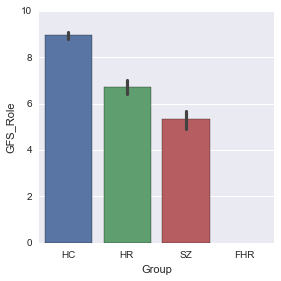

In [100]:
sns.factorplot(y='GFS_Role',x='Group',units='ID',ci=68,kind='bar',data=raw)

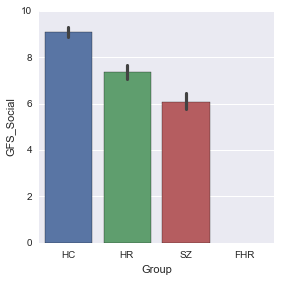

In [151]:
sns.factorplot(y='GFS_Social',x='Group',units='ID',ci=68,kind='bar',data=raw)

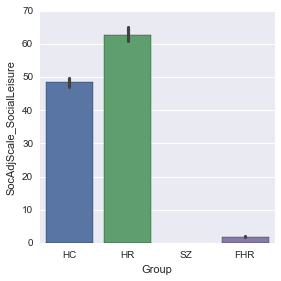

In [101]:
sns.factorplot(y='SocAdjScale_SocialLeisure',x='Group',units='ID',ci=68,kind='bar',data=raw)

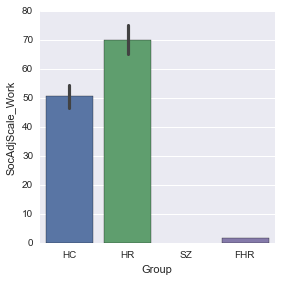

In [154]:
sns.factorplot(y='SocAdjScale_Work',x='Group',units='ID',ci=68,kind='bar',data=raw)